<a href="https://colab.research.google.com/github/aarunishsinha/SKFR-Python/blob/main/SKFR_tensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [3]:
import torch
print(torch.__version__)
print(torch.version.cuda)

1.10.0+cu111
11.1


In [4]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install -q torch-geometric

     |████████████████████████████████| 7.9 MB 3.9 MB/s 
     |████████████████████████████████| 3.5 MB 4.0 MB/s 
     |████████████████████████████████| 325 kB 4.3 MB/s 
     |████████████████████████████████| 407 kB 33.1 MB/s 
     |████████████████████████████████| 45 kB 3.5 MB/s 


## Importing Libraries

In [5]:
import numpy as np
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score as nmi, adjusted_rand_score as ari
from sklearn.cluster import KMeans
import random
import warnings
warnings.filterwarnings('ignore')

import tqdm
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid, Reddit, Yelp
from torch_geometric.data import Data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Utility Functions

In [6]:
def zscore(vec):
    m = torch.mean(vec)
    s = torch.std(vec)
    if s!=0:
        zs = (vec-m)/s
    else:
        zs = vec-m
    return zs

## SKFR1
A pytorch implementation of the SKFR algorithm

Reference : [paper](https://arxiv.org/abs/2002.08541)

In [7]:
def skfr1(X,Class,classes,sparsity):
    features = X.shape[0]
    cases = X.shape[1]
    criteria = torch.zeros(features).to(device)

    for i in range(features):
        X[i,:] = zscore(X[i,:])

    switched = True
    iternum = 1
    loss_list = []
    while switched and iternum < 20:
        center = torch.zeros((features,classes)).to(device)
        members = torch.zeros(classes).to(device)
        for j in range(cases):
            i = Class[j]
            center[:,i] = center[:,i] + X[:,j]
            members[i] = members[i] + 1
        for j in range(classes):
            if members[j]>0:
                center[:,j] = center[:,j]/members[j]
        criteria = torch.matmul(torch.mul(center, center), members.T)
        index = torch.LongTensor([i for i in range(len(criteria))]).to(device)
        sorted_criteria = sorted(zip(criteria,index))
        J = [x[1] for x in sorted_criteria]
        J = torch.LongTensor(J).to(device)
        J = J[:features-sparsity]
        # importantvec = list(set(wholevec)-set(J))
        for i in range(len(J)):
            center[J[i]] = torch.zeros(classes).to(device)
        del members, criteria, index, sorted_criteria, J
        distance = torch.sqrt(((X.T - center.T[:, np.newaxis])**2).sum(axis=2))
        switched = False
        for i in range(cases):
            j = torch.argmin(distance[:,i])
            if j!=Class[i]:
                switched =True
                Class[i] = j
        del distance
        WSStemp = torch.zeros(classes).to(device)
        for k in range(classes):
            tempIndex = torch.LongTensor(np.where(Class.cpu().numpy()==k)[0]).to(device)
            tempX = torch.zeros((features,len(tempIndex))).to(device)
            for j in range(len(tempIndex)):
                tempX[:,j] = X[:,tempIndex[j]]
            WSStemp[k] = torch.mean(((tempX.T-center[:,k]).T)**2)
        loss = torch.sum(WSStemp)
        loss_list.append(loss)
        print('Iteration : {}, Loss : {}'.format(iternum, loss))
        del tempX, tempIndex, WSStemp, loss
        iternum += 1
    return center, Class, loss_list

## Plotting Functions

In [8]:
def plot_data(X):
    plt.scatter(
    X[:, 0], X[:, 1],
    c='white', marker='o',
    edgecolor='black', s=50
    )
    plt.show()

def plot_clusters(X,centroids,cluster):
    sns.scatterplot(X[:,0], X[:, 1], hue=cluster)
    sns.scatterplot(centroids[:,0], centroids[:, 1], s=100, color='y')
    plt.xlabel('feature1')
    plt.ylabel('feature2')
    plt.show()

def plot_loss(loss_list):
    epochs = [i for i in range(len(loss_list))]
    plt.plot(epochs,loss_list)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

## Testing on Randomly Generated Data

Iteration : 1, Loss : 4.175202369689941
Iteration : 2, Loss : 0.5473364591598511
Iteration : 3, Loss : 0.4863407611846924
Iteration : 4, Loss : 0.477837473154068
Iteration : 5, Loss : 0.4784723222255707
Iteration : 6, Loss : 0.47927534580230713
Iteration : 7, Loss : 0.47897017002105713
Iteration : 8, Loss : 0.47930091619491577
Iteration : 9, Loss : 0.4794018566608429
Iteration : 10, Loss : 0.4794810712337494
Iteration : 11, Loss : 0.47963693737983704
Iteration : 12, Loss : 0.47994595766067505
Iteration : 13, Loss : 0.4799056947231293


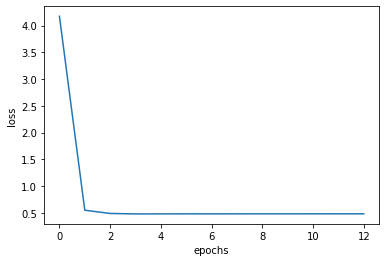

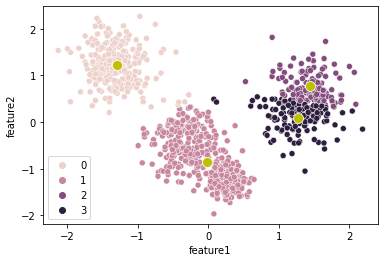

In [9]:
features = 2
cases = 1000
k = 4
sparsity = 2
X_random = np.random.normal(0,1,size=(features,cases//k))
j = 4
p = 1
for i in range(k-1):
    tmp = np.random.normal(j,2,size=(features,cases//k))
    if i%2==0:
        tmp[0] = -1*tmp[0]
    j+=4
    X_random = np.concatenate((X_random,tmp),axis=1)

X_random = torch.FloatTensor(X_random)
X_random = X_random.to(device)

Class = np.array(random.choices([i for i in range(k)],k=cases))
Class = torch.LongTensor(Class.tolist()).to(device)

centroids, cluster, loss_list = skfr1(X_random,Class,k,sparsity)

plot_loss(loss_list)
plot_clusters(X_random.T.cpu(),centroids.T.cpu(),cluster.cpu())